In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

import logging
logging.basicConfig(level=logging.ERROR)

CPython 3.8.3
IPython 7.16.1

numpy 1.18.5
pandas 1.0.5
torch 1.4.0
transformers 3.0.2


In [ ]:
import transformers
import torch
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

df = pd.read_csv('dataset.csv')

df_train = pd.read_csv('train.csv')
display(df_train.head(3))
df_test = pd.read_csv('dev.csv')
#display(df_test.head(3))


,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True


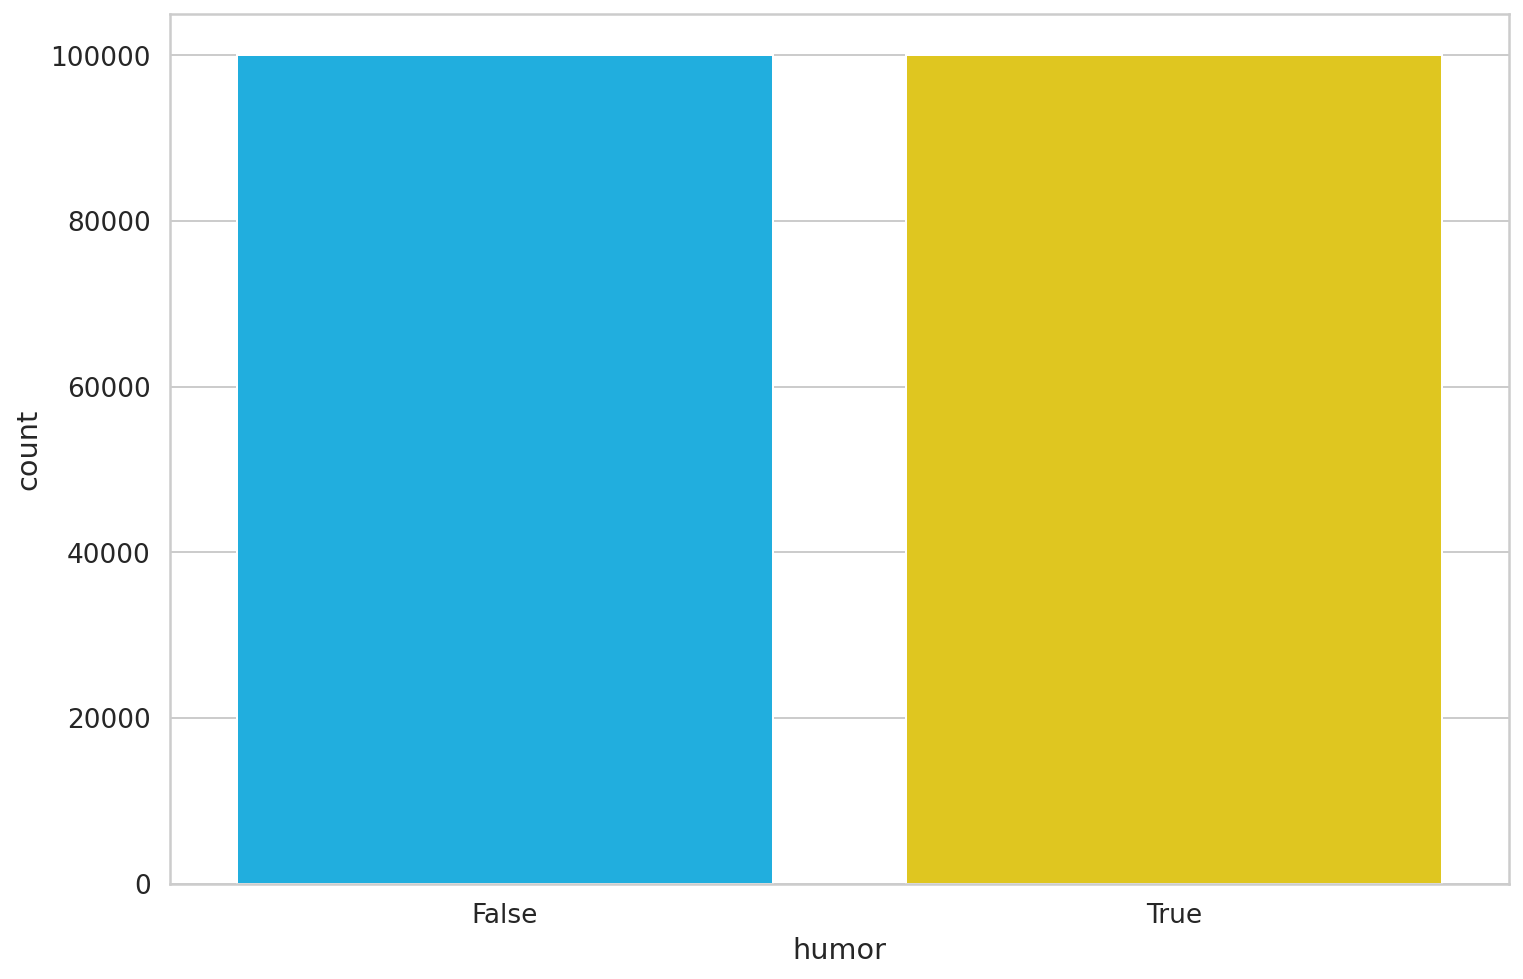

In [ ]:
sns.countplot(df.humor)
plt.xlabel('humor');

In [ ]:
PRE_TRAINED_MODEL_NAME = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokens = tokenizer.tokenize(df_train.text[0])
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {df_train.text[0]}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Joe biden rules out 2020 bid: 'guys, i'm not running'
   Tokens: ['Joe', 'Ġbid', 'en', 'Ġrules', 'Ġout', 'Ġ2020', 'Ġbid', ':', "Ġ'", 'gu', 'ys', ',', 'Ġi', "'m", 'Ġnot', 'Ġrunning', "'"]
Token IDs: [18393, 2311, 225, 1492, 66, 2760, 2311, 35, 128, 5521, 2459, 6, 939, 437, 45, 878, 108]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id


('</s>', 2)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id


('<s>', 0)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id


('<pad>', 1)

In [ ]:
encoding = tokenizer.encode_plus(
  df_train.text[0],
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([    0, 18393,  2311,   225,  1492,    66,  2760,  2311,    35,   128,
         5521,  2459,     6,   939,   437,    45,   878,   108,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['<s>',
 'Joe',
 'Ġbid',
 'en',
 'Ġrules',
 'Ġout',
 'Ġ2020',
 'Ġbid',
 ':',
 "Ġ'",
 'gu',
 'ys',
 ',',
 'Ġi',
 "'m",
 'Ġnot',
 'Ġrunning',
 "'",
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [ ]:
token_lens = []
for txt in df.text[1:100]:
  tokens = tokenizer.encode(txt, max_length=40)
  token_lens.append(len(tokens))

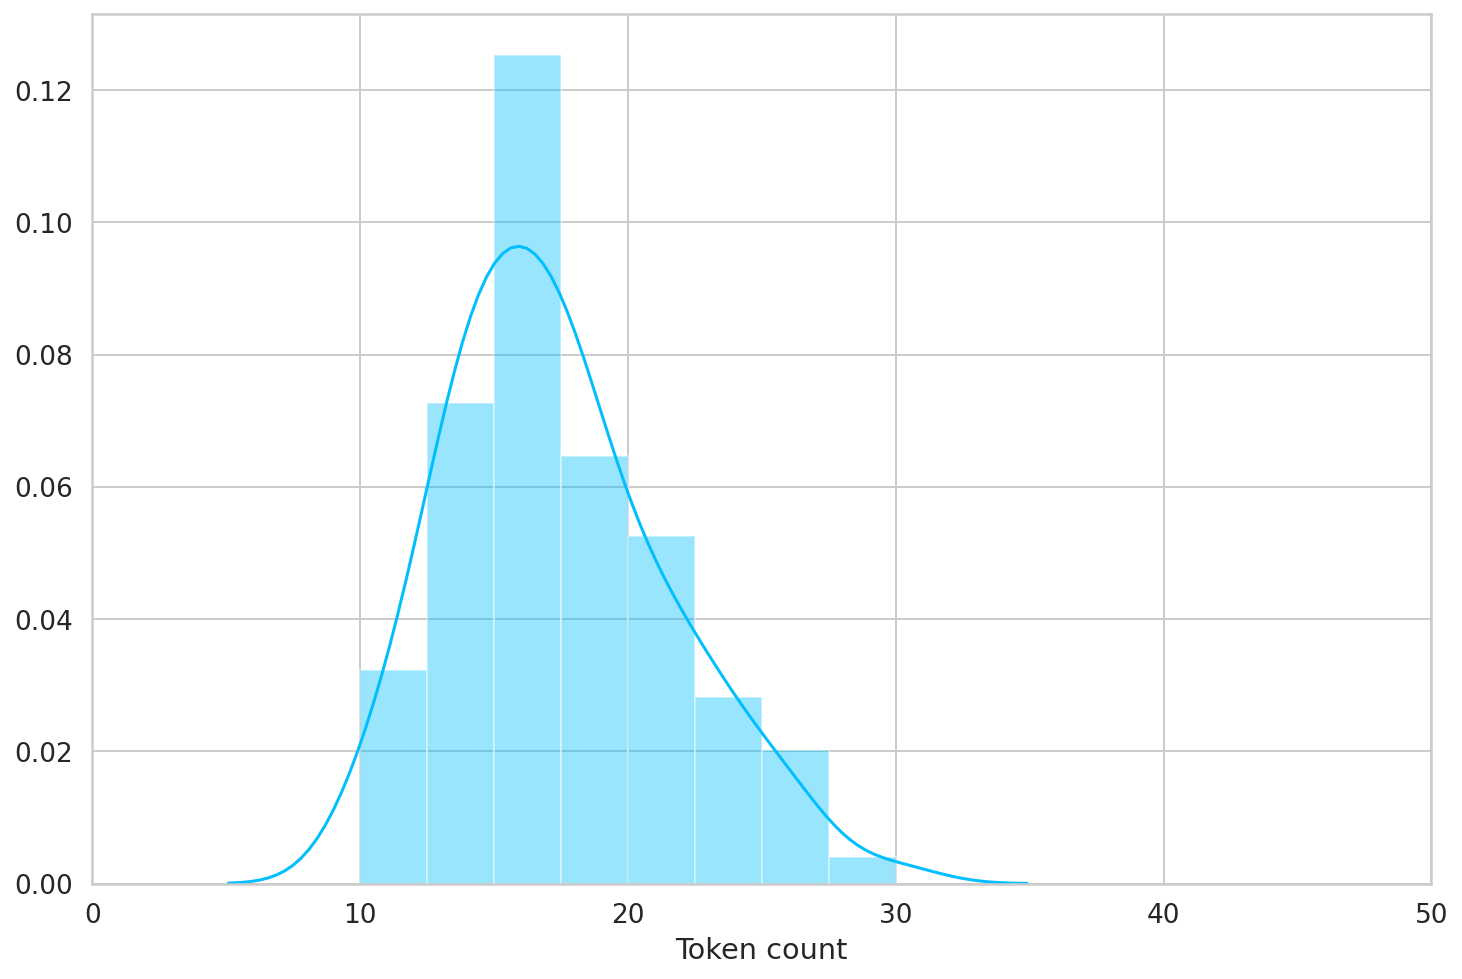

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 50]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 40

class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.humor.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=10
  )


In [ ]:
BATCH_SIZE = 128
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

torch.Size([128, 40])
torch.Size([128, 40])
torch.Size([128])


In [ ]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
last_hidden_state, pooled_output = roberta_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 1024])

In [ ]:
class_names = ['True', 'False']

In [ ]:
class HumorClassifier(nn.Module):
  def __init__(self, n_classes):
    super(HumorClassifier, self).__init__()
    self.bert = roberta_model.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = HumorClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([128, 40])
torch.Size([128, 40])


In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
print(device)

cuda:0


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
  )
  print(f'test loss {test_loss} accuracy {test_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['test_acc'].append(test_acc)
  history['test_loss'].append(test_loss)
  if test_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_roberta.bin')
    best_accuracy = test_acc

Epoch 1/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.05460403133258224 accuracy 0.9815875000000001


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.03494899860247017 accuracy 0.990025

Epoch 2/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.01921843014471233 accuracy 0.99416875


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.04438689664845316 accuracy 0.9879

Epoch 3/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.009847482824884355 accuracy 0.9972000000000001


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.03944230517491508 accuracy 0.99165

Epoch 4/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.0056640216242522 accuracy 0.9985375000000001


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.05501163408335762 accuracy 0.9911000000000001

Epoch 5/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.0033959488401189447 accuracy 0.999075


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.060768666025548694 accuracy 0.9917250000000001

Epoch 6/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.0026862114245072006 accuracy 0.99933125


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.06427270419354113 accuracy 0.990975

Epoch 7/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.00173641769438982 accuracy 0.9995312500000001


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.06602895401861554 accuracy 0.9914000000000001

Epoch 8/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.0014942596197128296 accuracy 0.99965


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.06466508862345269 accuracy 0.9915

Epoch 9/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.0006129061821848154 accuracy 0.9998312500000001


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.0838322320911355 accuracy 0.9906

Epoch 10/10
----------


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

Train loss 0.0003359139816835523 accuracy 0.9999


<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

test loss 0.08085375654023176 accuracy 0.990975

CPU times: user 3h 25min 13s, sys: 15min 19s, total: 3h 40min 32s
Wall time: 3h 40min 34s


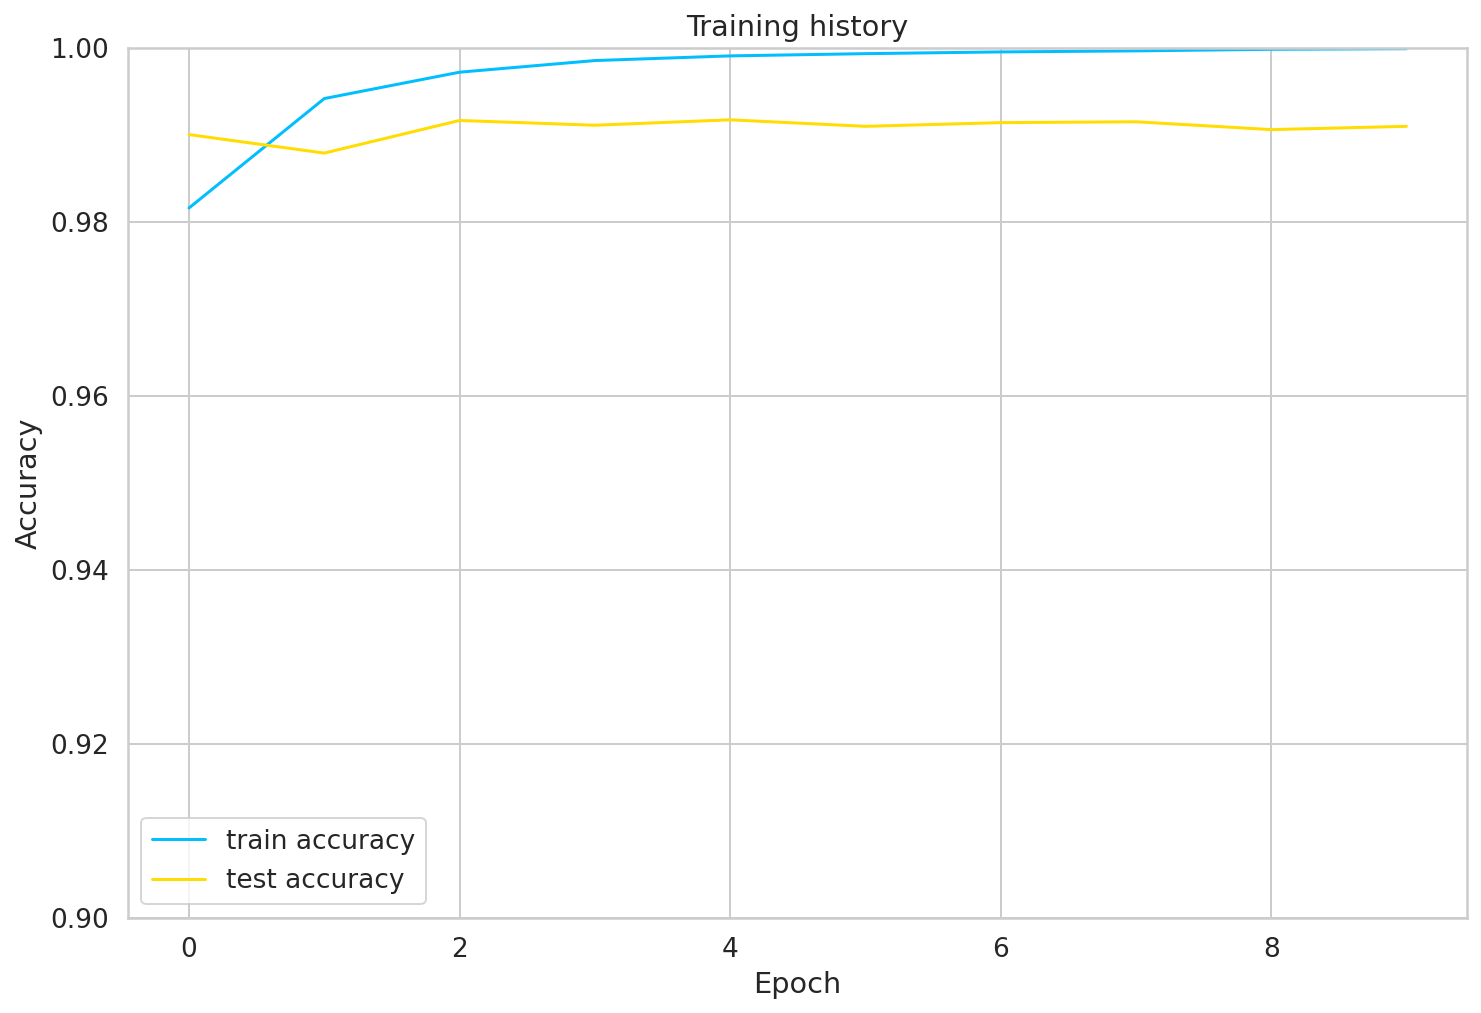

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['test_acc'], label='test accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.9, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

0.990975

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'targets': torch.tensor(target, dtype=torch.long)
<ipython-input-15-fb787b9223b7>:27: Depr

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

        True       0.99      0.99      0.99     19918
       False       0.99      0.99      0.99     20082

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



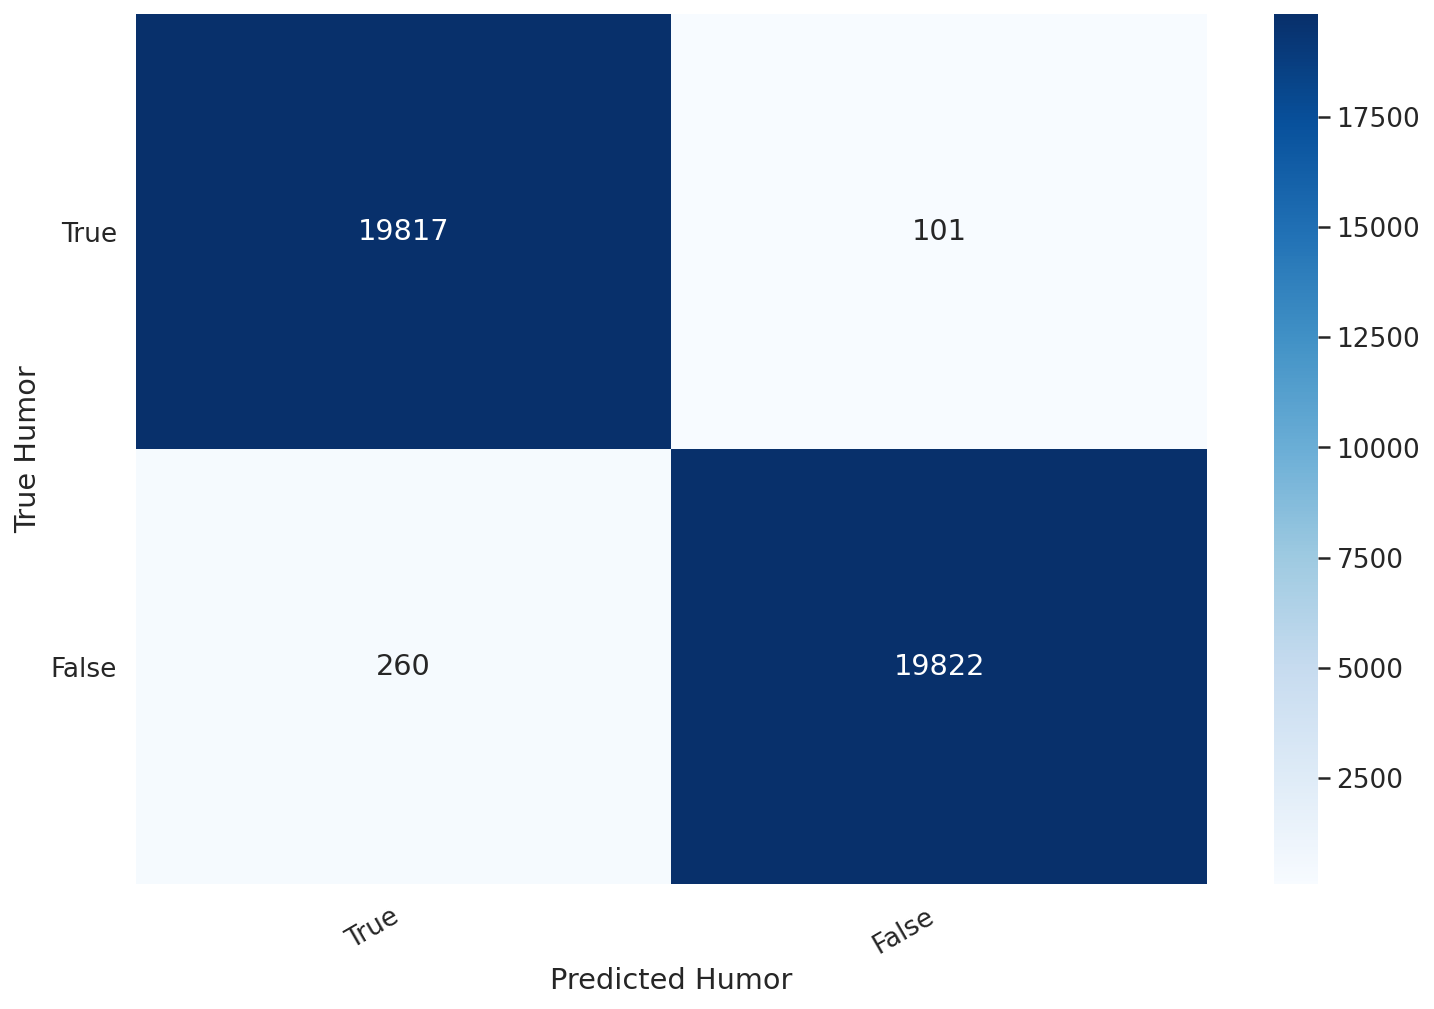

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Humor')
  plt.xlabel('Predicted Humor');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
!pip install transformers
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install seaborn

     |████████████████████████████████| 890kB 6.9MB/s 
     |████████████████████████████████| 3.0MB 13.0MB/s 
     |████████████████████████████████| 890kB 36.6MB/s 
     |████████████████████████████████| 1.1MB 31.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=986a6a7b5bffcc5a5094f033d6cedfb1b3eff7f224f499b90ce4d4ddf8969dcf
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
print(roberta_model.config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [ ]:
import transformers
import torch
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
print(roberta_model.config)


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [ ]:
PRE_TRAINED_MODEL_NAME = 'roberta-base-openai-detector'
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
roberta_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
print(roberta_model.config)

RobertaConfig {
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

